# Рекомендация тарифов

Исходные данные -  данные о поведении клиентов, которые перешли на новые тарифы сотового оператора. Нужно построить модель для задачи классификации, которая выберет подходящий тариф для нового клиента.

Целевая метрика -  *accuracy* не менее 0.75.

In [1]:
import pandas as pd
from sklearn.tree import DecisionTreeClassifier
from sklearn.linear_model import LogisticRegression 
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score
from sklearn.model_selection import train_test_split
import joblib
import numpy as np
from matplotlib import pyplot as plt
from sklearn.model_selection import GridSearchCV

## Предварительный анализ данных

In [2]:
df = pd.read_csv('users_behavior.csv')

In [3]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3214 entries, 0 to 3213
Data columns (total 5 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   calls     3214 non-null   float64
 1   minutes   3214 non-null   float64
 2   messages  3214 non-null   float64
 3   mb_used   3214 non-null   float64
 4   is_ultra  3214 non-null   int64  
dtypes: float64(4), int64(1)
memory usage: 125.7 KB


In [4]:
df.head()

,calls,minutes,messages,mb_used,is_ultra
0,40.0,311.90,83.0,19915.42,0
1,85.0,516.75,56.0,22696.96,0
2,77.0,467.66,86.0,21060.45,0
3,106.0,745.53,81.0,8437.39,1
4,66.0,418.74,1.0,14502.75,0


## Деление данных на выборки

**Разбиение данных на выборки**

| Выборка      | Доля от общего количества данных, % |
| ----------- | ----------- |
| Обучающая (train)     | 60       |
| Валидационная (valid)   | 20        |
| Тестовая (test)   | 20        |

Сперва отделим тестовую выборку, потом оставшиеся данные поделим на обучающую и валидационную

In [5]:
df_1, df_test = train_test_split(df, test_size=0.2, random_state=20032022)
df_train, df_valid = train_test_split(df_1, test_size=.25, random_state=20032022)
#print(df_train.shape, df_test.shape, df_valid.shape, df_1.shape)

In [6]:
features_train = df_train.drop(['is_ultra'], axis=1)
target_train = df_train['is_ultra']

features_valid = df_valid.drop(['is_ultra'], axis=1)
target_valid = df_valid['is_ultra']

features_test = df_test.drop(['is_ultra'], axis=1)
target_test = df_test['is_ultra']

In [7]:
print(f'Размер обучающей выборки - {df_train.shape[0]} - {df_train.shape[0] / df.shape[0]:.0%} от первоначального датасета')
print(f'Размер валидационной выборки - {df_valid.shape[0]} - {df_valid.shape[0] / df.shape[0]:.0%} от первоначального датасета')
print(f'Размер тестовой выборки - {df_test.shape[0]} - {df_test.shape[0] / df.shape[0]:.0%} от первоначального датасета')

Размер обучающей выборки - 1928 - 60% от первоначального датасета
Размер валидационной выборки - 643 - 20% от первоначального датасета
Размер тестовой выборки - 643 - 20% от первоначального датасета


## Исследование моделей

### План исследования

Поскольку поставлена задача предсказания категориального признака (подойдет пользователю тариф или не подойдет) то рассматриваться будут модели-классификаторы:
- решающее дерево
- случайный лес
- логистическая регрессия

Варьироваться будут следующие параметры:
- максимальная глубина дерева (для решающего дерева и случайного леса)
- способ выбора признака: лучший или случайный (для решающего дерева)
- максимальное количество деревьев (для случайного леса)
- критерий принятия решения: Джини или энтропийный (для решающего дерева и случайного леса)
- количество итераций (для логистического регрессора)
- тип решателя: lbfgs или liblinear (для логистического регрессора)


*Примечание 1:*

*Вроде бы, энтропийный критерий лучше применять, если целевая дискретная переменная случайна. В нашем случае это скорее не так. Также, встречалась информация, что нет никаких четких правил для выбора критерия, нужно пробовать. Что же, буду пробовать*

*Примечание 2*

*liblinear в дополнение к дефолтному я взял потому что [в документации пишут](https://scikit-learn.org/stable/modules/generated/sklearn.linear_model.LogisticRegression.html), что он хорош для маленьких датасетов. Посмотрим, хорош ли. Заодно интересно сравнить методы между собой, [ведь один использует линейную аппроксимацию, а второй - квадратичную.](https://stackoverflow.com/questions/38640109/logistic-regression-python-solvers-definitions/52388406#52388406)*

### Решающее дерево

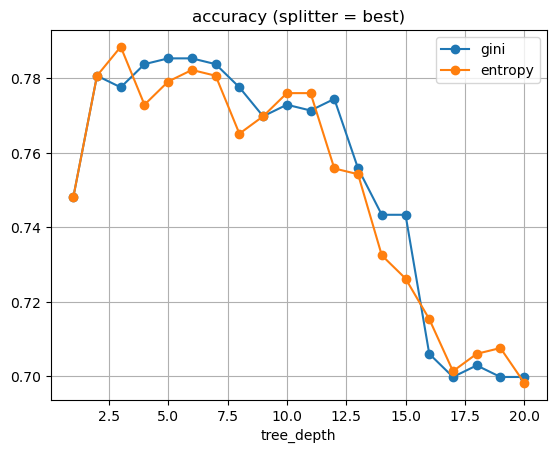

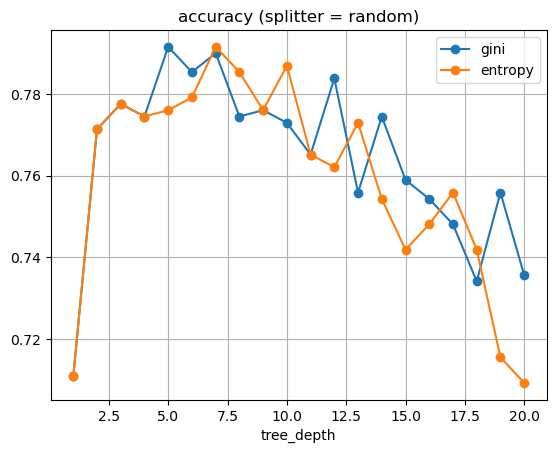


 Лучший результат 0.792 у решающего дерева с глубиной 5, критерием gini и способом выбора признака random


In [8]:
crit_list = ['gini', 'entropy']
splitter_list=['best', 'random']
best_model = None
best_result = 0
best_depth = 0
best_crit = ''

for s in splitter_list:
    for c in crit_list:
        result_graph = []
        depth = []
        for d in range(1, 21):
            model = DecisionTreeClassifier(random_state=20032022, max_depth = d, criterion=c, splitter=s) 
            model.fit(features_train, target_train)
            predictions = model.predict(features_valid)
            result = accuracy_score(target_valid, predictions)
            result_graph.append(result)
            depth.append(d)
            if result > best_result:
                best_model = model
                best_result = result
                best_depth = d
                best_crit = c
                best_split = s
        plt.plot(depth, result_graph, label=c, marker='o')
    plt.legend()
    plt.grid(True)
    plt.xlabel('tree_depth')
    plt.title('accuracy '+'(splitter = '+s+')')
    plt.show()
    
joblib.dump(best_model, 'best_tree.joblib')
print('\n', f'Лучший результат {round(best_result, 3)} у решающего дерева с глубиной {best_depth}, критерием {best_crit} \
и способом выбора признака {best_split}')

### Случайный лес

In [9]:
classifier = RandomForestClassifier()
parameters = { 'n_estimators': range (2, 11),
              'max_depth': range (1, 11),
              'min_samples_leaf': range (1,5),
              'criterion': ['gini', 'entropy'],
             'random_state': [20032022]}
grid = GridSearchCV(classifier, parameters)
grid.fit(features_train, target_train)
best_parameters = grid.best_params_
joblib.dump(grid.best_estimator_, 'best_forest1.joblib')
print(best_parameters)
print(f'Лучший результат - {round(accuracy_score(target_valid, grid.predict(features_valid)),3)}')

{'criterion': 'entropy', 'max_depth': 9, 'min_samples_leaf': 2, 'n_estimators': 9, 'random_state': 20032022}
Лучший результат - 0.798


In [10]:
best_forest = RandomForestClassifier(**best_parameters)
joblib.dump(best_forest, 'best_forest.joblib')

['best_forest.joblib']

### Логистический регрессор

In [11]:
solver_list = ['lbfgs', 'liblinear']

best_model = None
best_result = 0
best_iter = 0
best_solver = ''

for s in solver_list:
    for i in range (100, 1100, 100):
        model = LogisticRegression(random_state=20032022, solver=s, max_iter=i)
        model.fit(features_train, target_train)
        predictions = model.predict(features_valid)
        result = accuracy_score(target_valid, predictions)
        if result > best_result:
            best_model = model
            best_result = result
            best_solver = s
            best_iter = i
        #print(f'Solver {s}, iterations {i} - accuracy {result}')
joblib.dump(best_model, 'best_log.joblib')
print('\n', f'Лучший результат {round(best_result, 3)} у логистического регрессора с решателем {best_solver} \
и числом итераций {best_iter}')


 Лучший результат 0.733 у логистического регрессора с решателем lbfgs и числом итераций 100


### Вывод

**Получается, что лучшая из моделей - это случайный лес из 9 деревьев с глубиной 3 и критерием Джини**.

- Точность в порядке убывания: Случайный лес->Решающее дерево->Логистический регрессор
- Деревья с большей глубиной более склонны к переобучению. 
- В логистическом регрессоре метод с квадратичной аппроксимацией более точен, чем с линейной
- Лучшие модели с одиночным деревом и случайным лесом по точности различаются незначительно (1-2%)

Проверим теперь лучшую из моделей на тестовой выборке.

## Проверка лучшей модели на тестовой выборке

In [12]:
model = joblib.load('best_forest1.joblib') 
model.fit(features_train, target_train)
predictions = model.predict(features_test)
result = accuracy_score(target_test, predictions)
print(result)

0.7978227060653188


### Вывод
Поставленная цель (accuracy >= 0,75) достигнута

## Проверка модели на адекватность

Посмотрим на баланс значений в таргете

In [13]:
print(f'Значений "1" - {target_test.sum() / target_test.shape[0]:.0%} от общего числа значений')

Значений "1" - 30% от общего числа значений


Предположим, я решил угадывать тариф пользователя. То есть, теперь переменная predictions будет заполнена случайными значениями либо 0, либо 1. Рассчитаем accuracy для тестовой выборки. Несколько раз.

А потом посмотрим, что будет, если вместо всех предсказаний всегда выдавать "0" или "1"

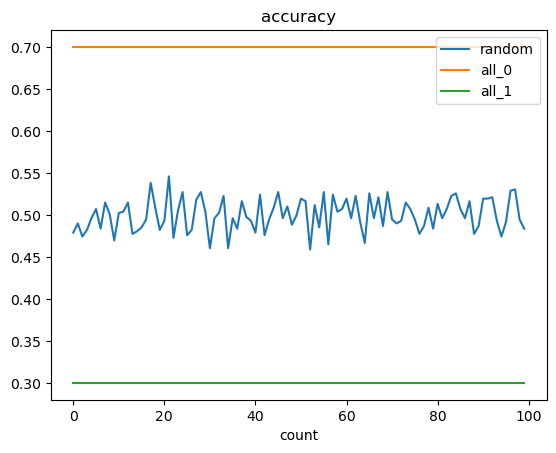

In [14]:
acc_rand = []
acc_0 = []
acc_1 = []
for i in range(100):
    predictions_rand = np.random.randint(2, size=df_test.shape[0])
    acc_rand.append(accuracy_score(target_test, predictions_rand))
    acc_0.append(accuracy_score(target_test, [0] * df_test.shape[0]))
    acc_1.append(accuracy_score(target_test, [1] * df_test.shape[0]))
    i += 1
plt.plot(acc_rand, label='random')
plt.plot(acc_0, label='all_0')
plt.plot(acc_1, label='all_1')
plt.xlabel('count')
plt.title('accuracy')
plt.legend()
plt.show()




### Вывод

Выбранная модель по точности не уступает случайному угадыванию или повторению одного и того же ответа. 